In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples_nosam.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,110,R.4SU.8.R.G.15.R.PSU.55.,-_-_-,12.32_21.81_22.62,0,0,1,0,0,...,1,0,0,0,1,0,0,7,0,0
1,1b23.cif1_R,110,R.4SU.8.R.G.48.R.PSU.55.,cSS_-_-,4.06_19.17_22.62,1,0,0,0,0,...,1,0,0,0,1,0,0,7,0,0
2,1b23.cif1_R,110,R.4SU.8.R.MIA.37.R.G.48.,-_-_cSS,33.9_36.92_4.06,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0
3,1b23.cif1_R,120,R.A.13.R.G.15.R.G.27.,-_-_-,10.88_28.24_19.46,1,0,0,0,0,...,1,0,0,0,1,0,0,9,1,0
4,1b23.cif1_R,120,R.A.9.R.U.25.R.A.46.,-_-_-,12.5_15.93_4.24,0,1,0,0,1,...,0,0,0,0,0,0,0,5,1,0


In [4]:
### !!!!! необходимые данные - train

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [5]:
triplexes_test = pd.read_csv('basetriples_sam_bal.csv', header=0, sep='\t')

In [6]:
triplexes_test.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,2qwy.cif1_C,123,C.A.9.C.U.12.C.A.41.,-_-_-,15.48_20.35_9.44,1,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,2qwy.cif1_C,111,C.G.6.C.U.26.C.U.38.,cWW_-_tSW,10.21_7.35_8.39,1,0,0,0,1,...,0,0,0,0,0,0,0,2,0,1
2,2qwy.cif1_C,111,C.G.8.C.C.23.C.G.42.,cW._cWW_cWH,14.54_10.41_11.07,0,1,0,1,0,...,0,0,1,0,1,0,0,3,0,1
3,2qwy.cif1_C,111,C.A.9.C.G.22.C.C.43.,..._cWW_cWH,15.07_10.65_12.28,0,1,0,1,0,...,0,0,1,0,1,0,0,3,1,1
4,2qwy.cif1_C,111,C.U.11.C.U.21.C.A.45.,-_cWW_cWH,14.62_10.42_8.29,0,1,0,1,0,...,0,0,0,0,0,0,0,2,0,1


In [7]:
### !!!!! необходимые данные - test

triplexes_test_data = triplexes_test.iloc[:, 5:475]
triplexes_test_target = triplexes_test.iloc[:, 476]

In [8]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [9]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

In [10]:
rf_classifier.fit(triplexes_data, triplexes_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [11]:
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)

In [12]:
#PREDICTED PROBABILITIES
for index, row in triplexes_test.iterrows():
    if triplexes_test_target[index] != prediction_result[index]:
        print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba[index][1])

111 C.G.6.C.U.26.C.U.38. cWW_-_tSW 10.21_7.35_8.39 PROBA:  0.43320114953969
111 C.G.8.C.C.23.C.G.42. cW._cWW_cWH 14.54_10.41_11.07 PROBA:  0.4390400731255673
111 C.A.9.C.G.22.C.C.43. ..._cWW_cWH 15.07_10.65_12.28 PROBA:  0.37719574919976373
111 C.U.12.C.U.20.C.A.46. -_cWW_cWH 15.24_10.24_8.27 PROBA:  0.4876878698716853
111 C.A.24.C.U.40.C.A.41. cWW_-_tSH 10.76_6.42_10.34 PROBA:  0.4326070508293589
112 A.G.30.A.C.41.A.C.87. -_-_- 13.63_14.78_10.76 PROBA:  0.6362967990646756
111 A.G.11.A.C.44.A.G.58. cSS_cWW_- 5.67_10.78_13.72 PROBA:  0.12891027367912117
111 A.A.12.A.G.43.A.C.59. cSS_cWW_- 5.69_10.45_8.43 PROBA:  0.15253261088184833
111 A.A.24.A.U.64.A.A.85. -_cWW_tWS 9.81_10.55_9.31 PROBA:  0.024175386240506653


AUC_TRAIN =  0.885156435371963

AUC =  0.7722323049001816


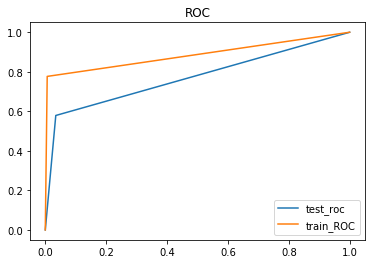

Probability density for train


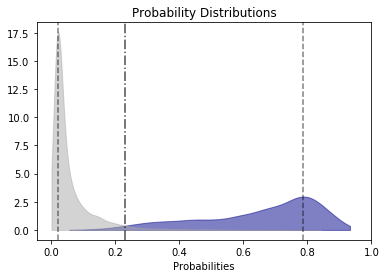

Probability density for test


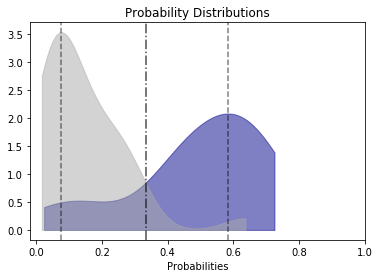


[[28  1]
 [ 8 11]]
CONFUSION MATRIX
Predicted   0   1  All
Actual                
0          28   1   29
1           8  11   19
All        36  12   48


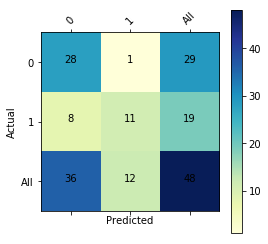


REPORT
             precision    recall  f1-score   support

          0       0.78      0.97      0.86        29
          1       0.92      0.58      0.71        19

avg / total       0.83      0.81      0.80        48

ACCURACY =  0.8125
-----------------


In [13]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_train)
auc_train = metrics.roc_auc_score(triplexes_target, prediction_train)
print("AUC_TRAIN = ", auc_train)
    
#---------------------------------
print("")
fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  prediction_result)
auc = metrics.roc_auc_score(triplexes_test_target, prediction_result)
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='test_roc')
line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Probability density for train")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Probability density for test")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")
